In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from math import exp
import matplotlib.pyplot as plt

# Modeling

This notebook will go through the modeling process and evaluation

Lets first load in the dataset from the cleaning and eda notebook

In [2]:
df = pd.read_csv('cleaned_dataset.csv')
df = df.drop(columns = ['Unnamed: 0'])

Great lets now implement our train test split with a test size of 0.20

In [3]:
df["label"] = df["label"].astype(str).str.strip()

X = df.drop(columns=["label"])
y = (df["label"] == ">50").astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42) #Set the random state for reproducible results

## Logistic Regression

Now we are going to use a column transformer object to One Hot Encode all of our categorical columns at once and then scale all of our numerical columns at once. This transformer object will help avoid us from having to create a separate one hot encoding and scaling object for each column in the dataset. Instead with this we can separate all of our numerical and categorical columns into lists and then input them into our column transformer object to transform them into the desired result all at once. We can then use a pipeline object to send our data through those preprocessing steps and then into our final model which will either be a logistic regression or decision tree model. These two options were selected because in a business context I would prefer to create a model that is more understandable. Logistic regression and decision tree classifiers allow us to see which variables have the highest impact on predictions while other classifiers such as gradient boosting classifiers, neural networks and XGBoost models do not allow for this type of output

We will first test a base logistic regression model below

In [4]:
categorical = [ #Create the list of categorical variables
    'class_of_worker_grouped',
    'education_grouped',
    'marital_stat_grouped',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'sex',
    'ft_or_pt_grouped',
    'citizenship_grouped',
    'veterans_benefits',
    'has_financial_activity',
    'num_persons_worked_for_employer'
]

numerical = [ #Create the list of numerical variables
    'age',
    'weeks_worked_in_year'
]

ca = ColumnTransformer(transformers = [
    ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), categorical), # One hot encoder object, if there is an unknown value the function will ignore it
    ("num", StandardScaler(), numerical) # Standard Scaler object with the standard inputs
    ],
    remainder = 'drop'
)

pipe_lr = Pipeline(steps = [
    ('preprocess', ca),
    ('lr', LogisticRegression(random_state = 42, max_iter = 1000))
    ])

pipe_lr.fit(X_train, y_train) #Call fit transform only on X_train so that we do not leak any scaling into the test set

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['class_of_worker_grouped',
                                                   'education_grouped',
                                                   'marital_stat_grouped',
                                                   'major_industry_code',
                                                   'major_occupation_code',
                                                   'race', 'sex',
                                                   'ft_or_pt_grouped',
                                                   'citizenship_grouped',
                                                   'veterans_benefits',
                                                   'has_financial_activity',
                                                   'num_persons_worked_for_employer']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'weeks_worked_in_year'])])),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

Let’s look at the classification report for the logistic regression model to better understand how the model is performing for each income group. Since this is a marketing use case, I care more about precision than recall for the $50,000+ class. If we target someone as a high earner, I want to be fairly confident that they actually are one. Sending ads to people who don’t fit that profile wastes valuable marketing resources. That does mean we might miss some true high earners which means a lower recall, but in this scenario I’m more comfortable missing a few qualified customers than spending resources on the wrong audience.

In [5]:
predictions = pipe_lr.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     25251
           1       0.69      0.35      0.46      2475

    accuracy                           0.93     27726
   macro avg       0.81      0.67      0.71     27726
weighted avg       0.92      0.93      0.92     27726



We can see here that the precision on the $50,000+ class has a value of 0.69 which is a significant result in this case. This means that when we predict a person makes over 50,000 we are correct with that prediction 69 percent of the time which is a very high success rate. The recall sits at 0.35 which is quite low but at an acceptable level

Lets also check the roc_auc_score of the model which can tell us how well the model does at separating the two classes. It tells us if you randomly pick one person who makes >50K and one person who makes <=50K, what is the probability that the model will correctly give a higher score to the person who actually makes more

In [6]:
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_proba_lr))

0.9025414095011338


We can see that a score of 0.902 is very good as the metric is measured out of 1 so we are getting good separation from the model

## Decision Tree Classifier

Lets see if we can improve upon these logistic regression classification scores with the decision tree classifier

In [7]:
pipe_dt = Pipeline(steps = [
    ('preprocess', ca),
    ('lr', DecisionTreeClassifier(random_state = 42))
    ])

pipe_dt.fit(X_train, y_train) #Call fit transform only on X_train so that we do not leak any scaling into the test set

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['class_of_worker_grouped',
                                                   'education_grouped',
                                                   'marital_stat_grouped',
                                                   'major_industry_code',
                                                   'major_occupation_code',
                                                   'race', 'sex',
                                                   'ft_or_pt_grouped',
                                                   'citizenship_grouped',
                                                   'veterans_benefits',
                                                   'has_financial_activity',
                                                   'num_persons_worked_for_employer']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'weeks_worked_in_year'])])),
                ('lr', DecisionTreeClassifier(random_state=42))])

In [8]:
predictions = pipe_dt.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     25251
           1       0.40      0.39      0.39      2475

    accuracy                           0.89     27726
   macro avg       0.67      0.67      0.67     27726
weighted avg       0.89      0.89      0.89     27726



In this model we can see a slight improvement in the recall, however, a steep dropoff in the precision. Based on our goal of increasing the precision to increase marketing efficiency, we are going to implement the logistic regression model in our final analysis

In [9]:
y_proba_dt = pipe_dt.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_proba_dt))

0.6722990708638803


We also had a significant dropoff in the roc_auc, meaning the model isnt able to disntiguish as well as the logistic regression model

## Class Imbalance Methods

We are also going to explore class imbalance methods to see if they will aid in our model scoring since this dataset contains several more rows with folks making less than 50,000 when compared to folks making more than 50,000

### Over Sampling

This method will essentially take a sample of data points that are classified into the minority class and duplicate them into the dataset so that the proportions between classes begin to even out. The imblearn library has a specific function RandomOverSampler that does this for us

In [10]:
pipe_lr_over = Pipeline(steps = [
    ('preprocess', ca),
    ('ros', RandomOverSampler(random_state=42)),
    ('lr', LogisticRegression(random_state = 42, max_iter = 1000))
    ])

pipe_lr_over.fit(X_train, y_train) #Call fit transform only on X_train so that we do not leak any scaling into the test set

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['class_of_worker_grouped',
                                                   'education_grouped',
                                                   'marital_stat_grouped',
                                                   'major_industry_code',
                                                   'major_occupation_code',
                                                   'race', 'sex',
                                                   'ft_or_pt_grouped',
                                                   'citizenship_grouped',
                                                   'veterans_benefits',
                                                   'has_financial_activity',
                                                   'num_persons_worked_for_employer']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'weeks_worked_in_year'])])),
                ('ros', RandomOverSampler(random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [11]:
predictions = pipe_lr_over.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     25251
           1       0.30      0.84      0.45      2475

    accuracy                           0.81     27726
   macro avg       0.64      0.83      0.67     27726
weighted avg       0.92      0.81      0.85     27726



Interesting results here. This does not quite meet the objective we were striving for in terms of a higher precision. Its almost as if the results of the precision and recall flipped as a result of adding random oversampling. Due to this result, we will likely not implement random oversampling

In [12]:
y_proba_lr_over = pipe_lr_over.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_proba_lr_over))

0.9031935288891448


roc-auc score however is very good with over sampling

### Under Sampling

This is the opposite of over sampling. This will remove samples from the majority class so that we can obtain a much more even class distribution. 

In [13]:
pipe_lr_under = Pipeline(steps = [
    ('preprocess', ca),
    ('ros', RandomUnderSampler(random_state=42)),
    ('lr', LogisticRegression(random_state = 42, max_iter = 1000))
    ])

pipe_lr_under.fit(X_train, y_train) #Call fit transform only on X_train so that we do not leak any scaling into the test set

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['class_of_worker_grouped',
                                                   'education_grouped',
                                                   'marital_stat_grouped',
                                                   'major_industry_code',
                                                   'major_occupation_code',
                                                   'race', 'sex',
                                                   'ft_or_pt_grouped',
                                                   'citizenship_grouped',
                                                   'veterans_benefits',
                                                   'has_financial_activity',
                                                   'num_persons_worked_for_employer']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'weeks_worked_in_year'])])),
                ('ros', RandomUnderSampler(random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [14]:
predictions = pipe_lr_under.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     25251
           1       0.31      0.84      0.45      2475

    accuracy                           0.82     27726
   macro avg       0.64      0.82      0.67     27726
weighted avg       0.92      0.82      0.85     27726



Looks like we received very similar scores to oversampling. We again will not implement this because we are striving for a higher precision as opposed to recall

In [15]:
y_proba_lr_under = pipe_lr_under.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_proba_lr_under))

0.9028451718483796


Ok so it seems like over and undersampling tended to increase the recall of the model, however the original goal was to increase the precision of the model, therefore, we are not going to implement the over or under sampling methods and will stick with the original logistic regression model which is still capable of handling class imbalance

## Final Model

### Parameter Grid Search

Now that we have our model choice, lets do a quick grid search on the model parameters to see if we can improve the model scoring any further. The main parameters I would like to tune are the l1 ration and C parameter. Together, these variables control the regularization of the model. In addition, I wanted to test the class weight variable to see if this could help with giving more weight to the minority class by penalizing the model for getting predictions of the minority class incorrect. We are going to set the scoring for the grid search to precision since we are optimizing for precision in this project. The grid search will iterate over all combinations of these parameters to find the best set that yields the highest precision

In [ ]:
#parameters = {
    #'lr__C': [0.01, 0.1, 1, 10],
    #'lr__max_iter':[1000],
    #'lr__penalty': ['elasticnet'],      
    #'lr__solver': ['saga'],               
    #'lr__l1_ratio': [0, 0.5, 1],
    #'lr__class_weight':[None, 'balanced']          
#}
#clf = GridSearchCV(pipe_lr, parameters, scoring = 'precision')
#clf.fit(X_train, y_train)
#print("Best C:", clf.best_params_)
#print("Best CV Precision:", clf.best_score_)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best C: {'lr__C': 0.01, 'lr__class_weight': None, 'lr__l1_ratio': 1, 'lr__max_iter': 1000, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
Best CV Precision: 0.6838414899206441


It looks like our best performing model does not include any balancing of the classes and has a C value of 0.01. Lets create a pipeline with these values as our final model

In [17]:
pipe_final = Pipeline(steps = [
    ('preprocess', ca),
    ('lr', LogisticRegression(random_state = 42,
                            C = 0.01,
                            max_iter = 1000,
                            penalty = 'elasticnet',
                            solver = 'saga',
                            l1_ratio = 1))
    ])

pipe_final.fit(X_train, y_train) #Call fit transform only on X_train so that we do not leak any scaling into the test set

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['class_of_worker_grouped',
                                                   'education_grouped',
                                                   'marital_stat_grouped',
                                                   'major_industry_code',
                                                   'major_occupation_code',
                                                   'race', 'sex',
                                                   'ft_or_pt_grouped',
                                                   'citizenship_grouped',
                                                   'veterans_benefits',
                                                   'has_financial_activity',
                                                   'num_persons_worked_for_employer']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'weeks_worked_in_year'])])),
                ('lr',
                 LogisticRegression(C=0.01, l1_ratio=1, max_iter=1000,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [18]:
predictions = pipe_final.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     25251
           1       0.70      0.30      0.42      2475

    accuracy                           0.93     27726
   macro avg       0.82      0.65      0.69     27726
weighted avg       0.91      0.93      0.91     27726



We can see that we were able to increase the precision, albeit by a very small amount but it was an improvement nonetheless

In [19]:
y_proba_final = pipe_final.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_proba_final))

0.9020378350852392


### Threshold Adjustment

We are now going to test how adjusting the probability threshold of the logistic regression model impacts model scoring

The code below will adjust the current logistic regression threshold to see how the precision and recall changes as a result of changing the threshold. The default for a logistic regression model is 0.50 where predicted probabilities above 0.50 are assigned to the 50,000+ class while any probabilities below 0.50 are assigned to the -50,000 class. The code below simulates thresholds in increments of 0.05 between 0.3 and 0.9 while also calculating the precision and recall for each of the threshold values

In [20]:
res = []
for t in np.arange(0.3, 0.9, 0.05):
    y_pred_t = (y_proba_final >= t).astype(int)
    p = precision_score(y_test, y_pred_t, pos_label=1)
    r = recall_score(y_test, y_pred_t, pos_label=1)
    print(f"Threshold={t:.2f} | Precision={p:.3f} | Recall={r:.3f}")
    res.append({'Threshold':t,
        'Precision':p,
        'Recall':r})
thres = pd.DataFrame(res)

Threshold=0.30 | Precision=0.546 | Recall=0.537
Threshold=0.35 | Precision=0.585 | Recall=0.476
Threshold=0.40 | Precision=0.625 | Recall=0.413
Threshold=0.45 | Precision=0.674 | Recall=0.361
Threshold=0.50 | Precision=0.705 | Recall=0.303
Threshold=0.55 | Precision=0.736 | Recall=0.253
Threshold=0.60 | Precision=0.761 | Recall=0.202
Threshold=0.65 | Precision=0.798 | Recall=0.150
Threshold=0.70 | Precision=0.816 | Recall=0.104
Threshold=0.75 | Precision=0.833 | Recall=0.059
Threshold=0.80 | Precision=0.841 | Recall=0.030
Threshold=0.85 | Precision=0.857 | Recall=0.010
Threshold=0.90 | Precision=0.750 | Recall=0.001


Lets plot these results above to give us a better idea of the impact of changing the threshold on recall and precision

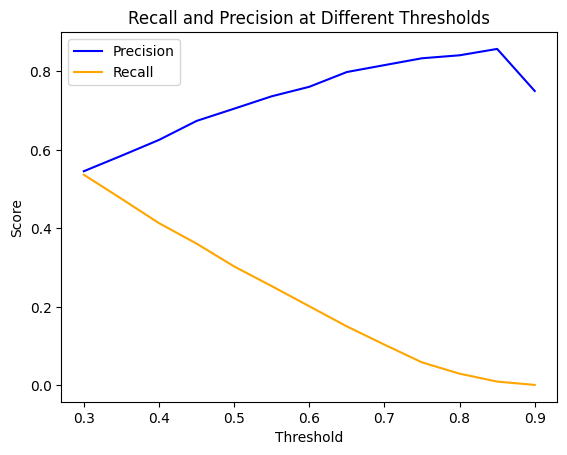

In [21]:
fig, ax = plt.subplots()

ax.plot(thres['Threshold'], thres['Precision'], label = 'Precision', color = 'blue')
ax.plot(thres['Threshold'], thres['Recall'], label = 'Recall', color = 'Orange')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Recall and Precision at Different Thresholds')
ax.legend()

We can see that as we increase the threshold, the precision increases while the recall decreases. This is because the model is forced to be more conservative when predicting someone to be in the high income class. They must have a probability greater than for example 0.70 to be classified into this class so naturally the model is not going to predict the high income class unless it is very sure of it with this high of a threshold. Conversely, recall decreases because if we only predict high income when the model is confident, then we are likely to miss several high income folks who received a calculated probability that was slightly lower than that threshold

### Final Model Results

To ensure that we are firmly predicting a high income customer and ensure an efficient targeting campaign, we are going to raise the threshold slightly to 0.55. This increases the precision just a bit more while not sacrificing too much more of recall. 

In [22]:
threshold = 0.55
y_proba = pipe_final.predict_proba(X_test)[:, 1]
predictions = (y_proba >= threshold).astype(int)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     25251
           1       0.74      0.25      0.38      2475

    accuracy                           0.93     27726
   macro avg       0.83      0.62      0.67     27726
weighted avg       0.91      0.93      0.91     27726



In [ ]:
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.9020


We still maintained a great roc-auc score despite shifting the precision and recall with the threshold analysis. This further confirms this shift should not hurt model performance on a real marketing campaign

Great since we wanted model interpretibility lets go ahead and take a look at the variables that are the strongest predictors of both classes. At the output of the model, the coefficients are expressed in terms of log odds. A positive value indicates that as the feature value increases the probability of the individual earning over $50,000 increases. Conversely, negative coefficients increasing indicates the probability of an individual earning over $50,000 is less likely

In [24]:
feature_names = pipe_final.named_steps["preprocess"].get_feature_names_out()

# Get coefficients
coefficients = pipe_final.named_steps["lr"].coef_[0]

# Create dataframe
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

# Sort by coefficient value
coef_df_sorted = coef_df.sort_values(by="coefficient", ascending=False)

Lets convert this to an odds ratio which is more understandable in a business context. To do so we take the exponential of the coefficients above. Now all coefficients will be positive values. An odds ratio greater than 1 indicates a higher likelihood of earning above $50,000 while a value less than 1 indicates a lower likelihood. If the value is 1 then the feature has no effect. For example, if we have an odds ratio of 0.50, this indicates that for every one unit increase in this variable the odds of an income over $50,000 are reduced by 50%.

In [25]:
coef_df_sorted['coefficient'] = coef_df_sorted['coefficient'].apply(exp)

Lets export this to a csv for proper viewing and analysis

In [ ]:
#coef_df_sorted.to_csv('model_coefficients.csv')